# Mount Google Drive for the data uploading

In [2]:
from google.colab import drive
drive.mount('/content/drive')

import zipfile

def unzip_file(zip_path, extract_path):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)
    return

### Train data
train_zip_path = "/content/drive/MyDrive/Pneumonia_Classification/stage_2_train_images.zip"
train_extract_path = "/content/Data/stage_2_train_images"

unzip_file(train_zip_path,train_extract_path)


### Test data
test_zip_path = "/content/drive/MyDrive/Pneumonia_Classification/stage_2_test_images.zip"
test_extract_path = "/content/Data/stage_2_test_images"

unzip_file(test_zip_path,test_extract_path)


### Labels
labels_zip_path = "/content/drive/MyDrive/Pneumonia_Classification/stage_2_train_labels.csv.zip"
labels_extract_path = "/content/Data"

unzip_file(labels_zip_path,labels_extract_path)

ModuleNotFoundError: No module named 'google.colab'

# Import Libraries

In [ ]:
!pip install pytorch-lightning
!pip install pydicom
!pip install torchmetrics

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pydicom
from pathlib import Path
import cv2
from tqdm.notebook import tqdm

import torch
import torchvision
from torchvision import transforms
import torchmetrics
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger
import os

# Data Preprocessing

In [8]:
Root_path = Path('Data/stage_2_train_images/')
Save_path = Path('Data/Processed')

images_path = 'images/'
os.makedirs(images_path, exist_ok=True)

In [10]:
labels = pd.read_csv('Data/stage_2_train_labels.csv')
labels = labels.drop_duplicates('patientId')
labels.head(10)

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1
6,00569f44-917d-4c86-a842-81832af98c30,NaN,NaN,NaN,NaN,0
7,006cec2e-6ce2-4549-bffa-eadfcd1e9970,NaN,NaN,NaN,NaN,0
8,00704310-78a8-4b38-8475-49f4573b2dbb,323.0,577.0,160.0,104.0,1
10,008c19e8-a820-403a-930a-bc74a4053664,NaN,NaN,NaN,NaN,0
11,009482dc-3db5-48d4-8580-5c89c4f01334,NaN,NaN,NaN,NaN,0


## Plotting a sample of input images with labels

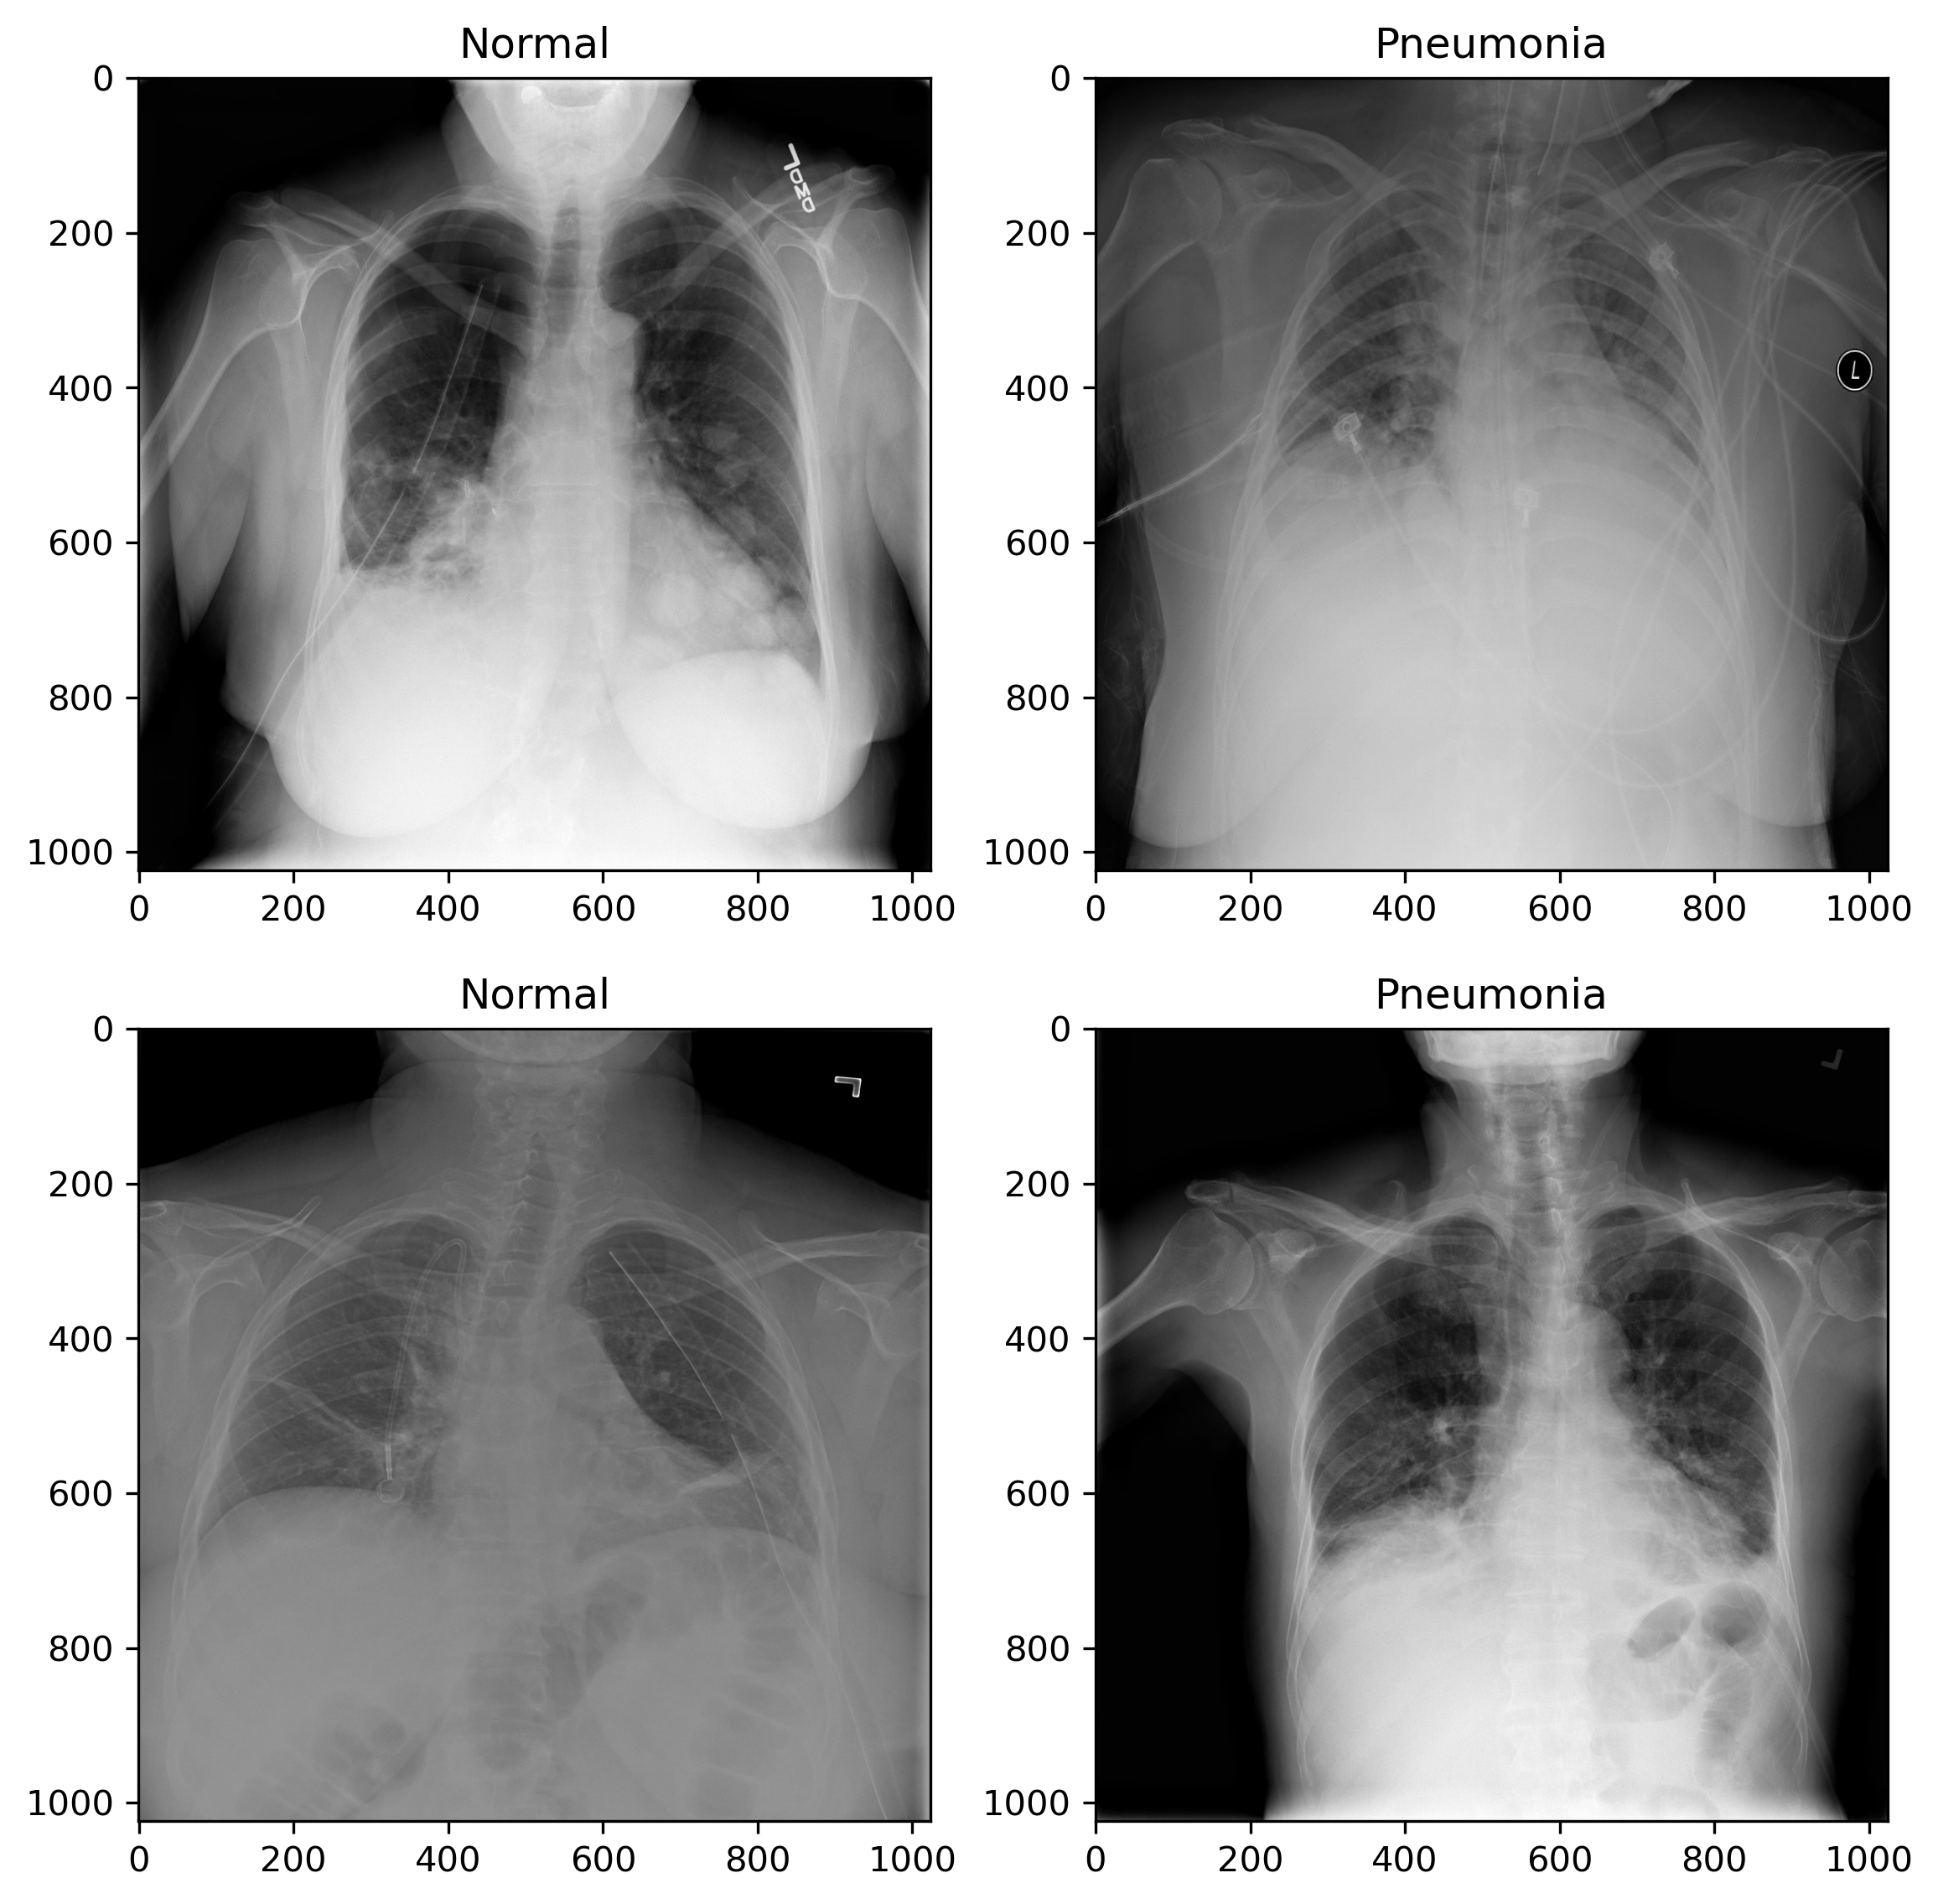

In [13]:
fig, ax = plt.subplots(2,2,figsize = (9,9) , dpi = 300 )

normal_patient_ids = labels[labels['Target'] == 0]['patientId'].reset_index(drop = True)
pneumonia_patient_ids = labels[labels['Target'] == 1]['patientId'].reset_index(drop = True)


for i in range(2):
      dcm_path = Root_path/normal_patient_ids[i]
      dcm_path = dcm_path.with_suffix('.dcm')
      dcm = pydicom.dcmread(dcm_path).pixel_array
      ax[i][0].imshow(dcm , cmap = 'gray')
      ax[i][0].set_title('Normal')

      dcm_path = Root_path/pneumonia_patient_ids[i]
      dcm_path = dcm_path.with_suffix('.dcm')
      dcm = pydicom.dcmread(dcm_path).pixel_array
      ax[i][1].imshow(dcm , cmap = 'gray')
      ax[i][1].set_title('Pneumonia')



plt.savefig(images_path+"sample_input.pdf")

## Normalization

In [15]:
sum = 0
sum_squared = 0

for c,patient_id in enumerate(tqdm(labels.patientId)):
    dcm_path = Root_path/patient_id
    dcm_path = dcm_path.with_suffix('.dcm')
    dcm = pydicom.dcmread(dcm_path).pixel_array/255

    dcm_array = cv2.resize(dcm , (224,224)).astype(np.float16)
    label = labels.Target.iloc[c]

    if c < 24000:
        current_save_path = Save_path/'train'/str(label)
    else:
        current_save_path = Save_path/'validation'/str(label)

    current_save_path.mkdir(parents = True, exist_ok = True)
    np.save(current_save_path/patient_id, dcm_array)


    normalizer = 224 * 224
    if c < 24000:
        sum += np.sum(dcm_array) / normalizer
        sum_squared += np.sum(dcm_array**2) / normalizer


  0%|          | 0/26684 [00:00<?, ?it/s]

In [17]:
mean = sum /24000
std = np.sqrt((sum_squared / 24000) - mean**2)
print(f"Mean: {mean} , std: {std}")

Mean: 0.49039623525191567 , std: 0.2479507326197431


# Data Loading

## Data Augmentation

In [19]:
train_transform = transforms.Compose([
                                        transforms.ToTensor(),
                                        transforms.Normalize(mean, std),
                                        transforms.RandomAffine( degrees = 15 , translate = (0,0.05) , scale = (0.9 , 1.1), shear = 10),
                                        transforms.RandomResizedCrop(224 , scale = (0.35,1))
                                        ])

test_transform = transforms.Compose([
                                        transforms.ToTensor(),
                                        transforms.Normalize(mean, std)
                                        ])

In [21]:
def load_file(path):
    return np.load(path).astype(np.float32)

train_dataset = torchvision.datasets.DatasetFolder(str(Save_path/"train"), loader = load_file ,extensions = 'npy', transform = train_transform )
val_dataset = torchvision.datasets.DatasetFolder(str(Save_path/"validation"), loader = load_file ,extensions = 'npy', transform = test_transform )

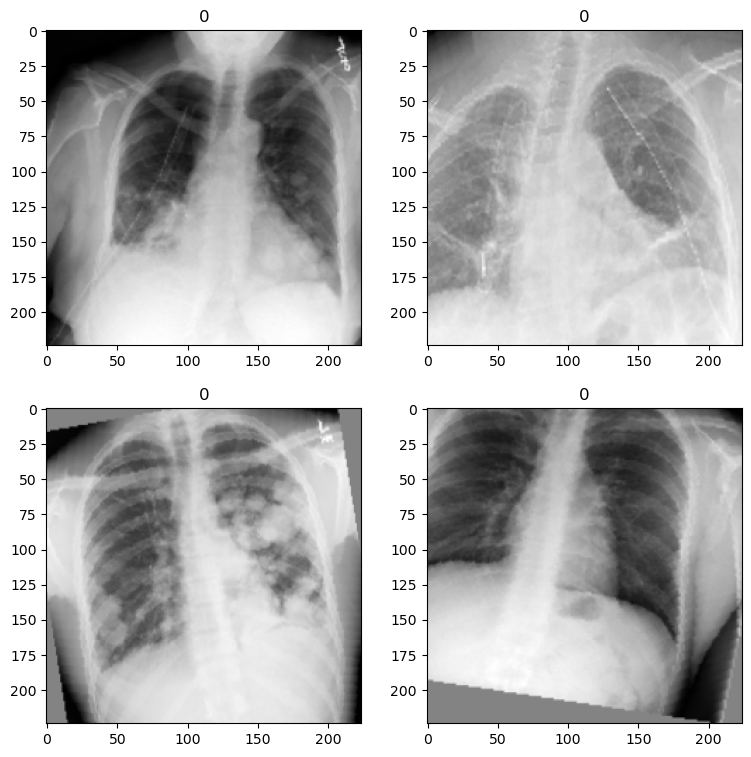

In [25]:
fig , ax = plt.subplots(2,2 , figsize = (9,9))
c = 0
for i in range(2):
    for j in range(2):
        ax[i][j].imshow(train_dataset[c][0].view(224,224), cmap = 'gray')
        ax[i][j].set_title(train_dataset[c][1])
        c += 1

plt.savefig(images_path+"augmented_input.pdf")

In [72]:
batch_n = 64
parallel_workers = 0

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = batch_n , num_workers = parallel_workers, shuffle = True)
test_loader = torch.utils.data.DataLoader(val_dataset, batch_size = batch_n , num_workers = parallel_workers, shuffle = False)

## Check the balance of the training dataset

Text(0, 0.5, 'Count')

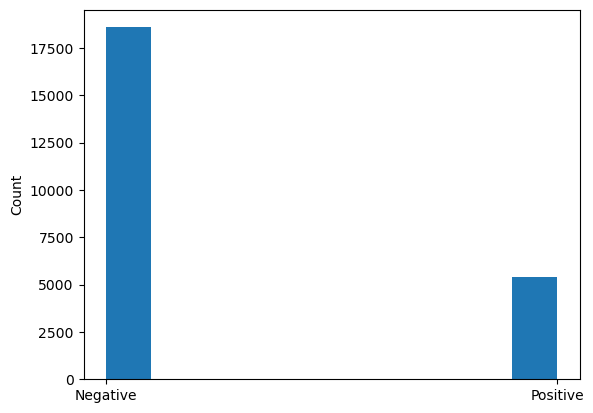

In [30]:
plt.hist(train_dataset.targets)
plt.xticks([0,1],['Negative','Positive'])
plt.ylabel('Count')


# Model Creation

In [60]:
class Pneumonia_classifier(pl.LightningModule):

    def __init__(self):
        super().__init__()
        self.model = torchvision.models.resnet18()
        self.model.fc = torch.nn.Linear(self.model.fc.in_features,1)
        self.model.conv1 = torch.nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

        self.optimizer = torch.optim.Adam(self.model.parameters(), lr = 1e-4)

        self.register_buffer("pos_weight", torch.tensor([3.0]))  # ✅ Fix device issue
        self.loss_fn = torch.nn.BCEWithLogitsLoss(pos_weight=self.pos_weight)


        self.train_acc = torchmetrics.Accuracy(task = 'binary')
        self.val_acc = torchmetrics.Accuracy(task = 'binary')

    def forward(self , data):
        pred = self.model(data)
        return pred

    def training_step(self , batch , batch_idx):
        x_ray , label = batch
        label = label.to(x_ray.device).float()
        prediction = self(x_ray)[:,0]
        loss = self.loss_fn(prediction,label)

        self.log('Train Loss' , loss)
        self.log('Step Train Acc' , self.train_acc((torch.sigmoid(prediction) > 0.5).int(), label.int()))

        return loss

    def on_train_epoch_end(self):
        self.log("Train Acc", self.train_acc.compute())
        self.train_acc.reset()


    def validation_step(self , batch , batch_idx):
        x_ray , label = batch
        label = label.to(x_ray.device).float()
        prediction = self(x_ray)[:,0]
        loss = self.loss_fn(prediction,label)

        self.log('Val Loss' , loss)
        self.log('Step Val Acc' , self.val_acc((torch.sigmoid(prediction) > 0.5).int(), label.int()))

        return loss

    def on_validation_epoch_end(self):
        self.log("Val Acc", self.val_acc.compute())
        self.val_acc.reset()

    def configure_optimizers(self):
        return [self.optimizer]


In [62]:
model = Pneumonia_classifier()

In [64]:
accelerator = "mps" if torch.backends.mps.is_available() else "cpu"
model.to(accelerator)

Pneumonia_classifier(
  (model): ResNet(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True

In [84]:
from pytorch_lightning.callbacks import EarlyStopping

early_stop = EarlyStopping(
    monitor="Val Acc",       
    patience=5,               
    mode="max"
)

In [86]:
checkpoint_callback = ModelCheckpoint(monitor = "Val Acc",
                                      save_top_k = 10,
                                      mode = "max",
                                      filename="pneumonia-{epoch:02d}-{Val Acc:.2f}")

In [88]:
trainer = pl.Trainer(
    devices = 1 ,
    accelerator = accelerator,
    logger = TensorBoardLogger(save_dir='./logs'),
    log_every_n_steps = 1,
    callbacks = [checkpoint_callback, early_stop],
    max_epochs = 50
)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [90]:
trainer.fit(model , train_loader , test_loader )


  | Name      | Type              | Params | Mode 
--------------------------------------------------------
0 | model     | ResNet            | 11.2 M | train
1 | loss_fn   | BCEWithLogitsLoss | 0      | train
2 | train_acc | BinaryAccuracy    | 0      | train
3 | val_acc   | BinaryAccuracy    | 0      | train
--------------------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.683    Total estimated model params size (MB)
71        Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

/Users/sima/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/Users/sima/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Training: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

In [92]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(device)

mps


In [94]:
model = Pneumonia_classifier.load_from_checkpoint(checkpoint_callback.best_model_path)
model.eval()
model.to(device)

Pneumonia_classifier(
  (model): ResNet(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True

In [102]:
preds = []
labels = []

model.eval()  # Important: turn off dropout/batchnorm

with torch.no_grad():
    for data, label in tqdm(test_loader):  # Use DataLoader here
        data = data.to(device).float()
        label = label.to(device)
        
        output = model(data).squeeze(1)  # shape: [batch_size]
        prediction = (torch.sigmoid(output) > 0.5).int()  # shape: [batch_size]

        preds.append(prediction.cpu())
        labels.append(label.cpu())

# Concatenate all predictions
preds = torch.cat(preds)
labels = torch.cat(labels)

  0%|          | 0/42 [00:00<?, ?it/s]

In [110]:
acc = torchmetrics.Accuracy(task = 'binary')(preds,labels)
precision = torchmetrics.Precision(task = 'binary')(preds,labels)
recall = torchmetrics.Recall(task = 'binary')(preds,labels)
f1 = torchmetrics.F1Score(task = 'binary')(preds,labels)
confusion_matrix = torchmetrics.ConfusionMatrix(num_classes = 2 , task = 'binary')(preds,labels)

print(f'Accuracy: {acc}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')
print(f'Confusion matrix: {confusion_matrix}')

Accuracy: 0.8233979344367981
Precision: 0.5823899507522583
Recall: 0.7652892470359802
F1 Score: 0.6614285707473755
Confusion matrix: tensor([[1747,  332],
        [ 142,  463]])


In [106]:
print(trainer.should_stop)

True
